In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import math
from google.colab import files
from keras import utils
from keras import layers
import json
from keras.preprocessing import image
import random
import cv2
import os
import dlib
import zipfile
from google.colab import files
from imutils import face_utils
import pandas as pd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with zipfile.ZipFile('/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('fer2013_images')

In [ ]:
num_classes = 7
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [ ]:
def get_images_and_labels(dataset):

  img_dir = img_dir = '/fer2013_images/' + str(dataset) + '/'
  img_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".gif"]
  images = []
  y = []

  for emotion in range(len(class_names)):
        img_dir_emotion = img_dir + class_names[emotion] + '/'
        # Loop over the files in the directory
        for filename in os.listdir(img_dir_emotion):
        # Check if the file is an image based on its extension
          if any(filename.endswith(extension) for extension in img_extensions):
              # Read the image and append it to the list of images
              img_path = os.path.join(img_dir_emotion, filename)
              img = cv2.imread(img_path)
              images.append(img)
              y.append(emotion)
  images = np.array(images)
  y = np.array(y)

  return images, y

In [ ]:
def shuffle_data(images, y):
  combined = list(zip(images, y))
  random.shuffle(combined)
  shuffled_im, shuffled_y = zip(*combined)
  shuffled_im = np.array(shuffled_im)
  shuffled_y = np.array(shuffled_y)
  return shuffled_im, shuffled_y

In [ ]:
train_images, train_y = get_images_and_labels('train')
test_images, test_y = get_images_and_labels('test')

In [ ]:
#Data preprocessing
train_images, train_y = shuffle_data(train_images, train_y)
test_images, test_y = shuffle_data(test_images, test_y)

# Normalization
train_images = train_images / 255.0
test_images = test_images / 255.0

In [ ]:
def plot_images(images, labels, predictions=None):
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].squeeze(), cmap='binary')
        # Show true and predicted classes.
        if predictions is None:
            xlabel = "True: {0}".format(class_names[labels[i]])
        else:
            xlabel = "True: {0}, Pred: {1}".format(class_names[labels[i]], class_names[predictions[i]])
        ax.set_xlabel(xlabel)
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

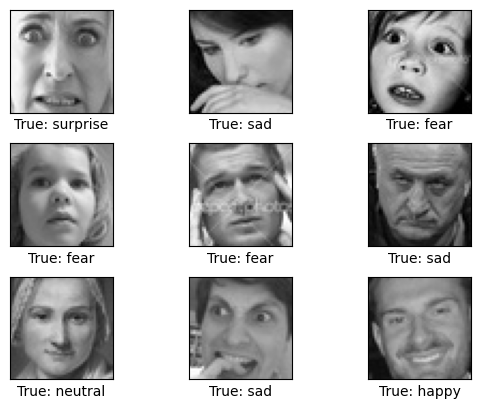

In [ ]:
#Plot examples of images
images = test_images[0:9]
cls_true = test_y[0:9]

plot_images(images=images, labels=cls_true)

In [ ]:
def dlib_landmarks_to_array(landmarks):
    return np.array([[landmarks.part(i).x, landmarks.part(i).y] for i in range(68)])

def compute_landmarks(images):
  #Create a dlib face detector
  detector = dlib.get_frontal_face_detector()
  #Create a dlib landmark predictor
  predictor = dlib.shape_predictor("/content/drive/MyDrive/Colab Notebooks/shape_predictor_68_face_landmarks.dat")

  landmarks_array = []  # Initialize an empty array to store the landmarks

  for img in range(images.shape[0]):
        img = np.uint8(images[img])  # Convert the image tensor to uint8 format
        dlib_rect = dlib.rectangle(0, 0, img.shape[1], img.shape[0])  # Create a dlib rectangle for the whole image
        landmarks = predictor(img, dlib_rect)  # Apply the facial landmark detection model
        landmarks_ar = dlib_landmarks_to_array(landmarks)
        landmarks_array.append(landmarks_ar)

  landmarks_array = np.array(landmarks_array)
  landmarks_array = landmarks_array / 48.0 - 0.5 #Normalization

  return [images, landmarks_array]

In [ ]:
x_train = compute_landmarks(train_images)
x_test = compute_landmarks(test_images)

In [ ]:
print('Size of training set: ', x_train[1].shape[0])
print('Size of test set:     ', x_test[0].shape[0])

Size of training set:  28709
Size of test set:      7178


In [ ]:
images_input_shape = (48, 48, 3)
landmarks_input_shape = (68, 2)

In [ ]:
input_images = keras.Input(shape=images_input_shape, name='images')

conv1 = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(input_images)
batch1 = layers.BatchNormalization()(conv1)

conv2 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(batch1)
batch2 = layers.BatchNormalization()(conv2)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(batch2)
drop2 = layers.Dropout(0.25)(pool2)

conv3 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(drop2)
batch3 = layers.BatchNormalization()(conv3)

conv4 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(batch3)
batch4 = layers.BatchNormalization()(conv4)
pool4 = layers.MaxPooling2D(pool_size=(2, 2))(batch4)
drop4 = layers.Dropout(0.25)(pool4)

conv5 = layers.Conv2D(256, kernel_size=(3, 3), activation='relu')(drop4)
batch5 = layers.BatchNormalization()(conv5)

conv6 = layers.Conv2D(256, kernel_size=(3, 3), activation='relu')(batch5)
batch6 = layers.BatchNormalization()(conv6)
pool6 = layers.MaxPooling2D(pool_size=(2, 2))(batch6)
drop6 = layers.Dropout(0.25)(pool6)

output_images = layers.Flatten()(drop6)

input_landmarks = keras.Input(shape=landmarks_input_shape, name='landmarks')
output_landmards = layers.Flatten()(input_landmarks)

concat = keras.layers.concatenate([output_images, output_landmards])

dence7 = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01), name='dence1')(concat)
batch7 = layers.BatchNormalization()(dence7)
drop7 = layers.Dropout(rate=0.25, name='drop4')(dence7)
output = layers.Dense(num_classes, activation='softmax', name='output')(drop7)

nn = keras.Model(inputs=[input_images,input_landmarks], outputs=output, name='Emotion_rec_model')
nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
nn.summary()


Model: "Emotion_rec_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 images (InputLayer)            [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 46, 46, 32)   896         ['images[0][0]']                 
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 46, 46, 32)  128         ['conv2d_6[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 conv2d_7 (Conv2D)              (None, 44, 44, 64)   18496       ['batch_normaliza

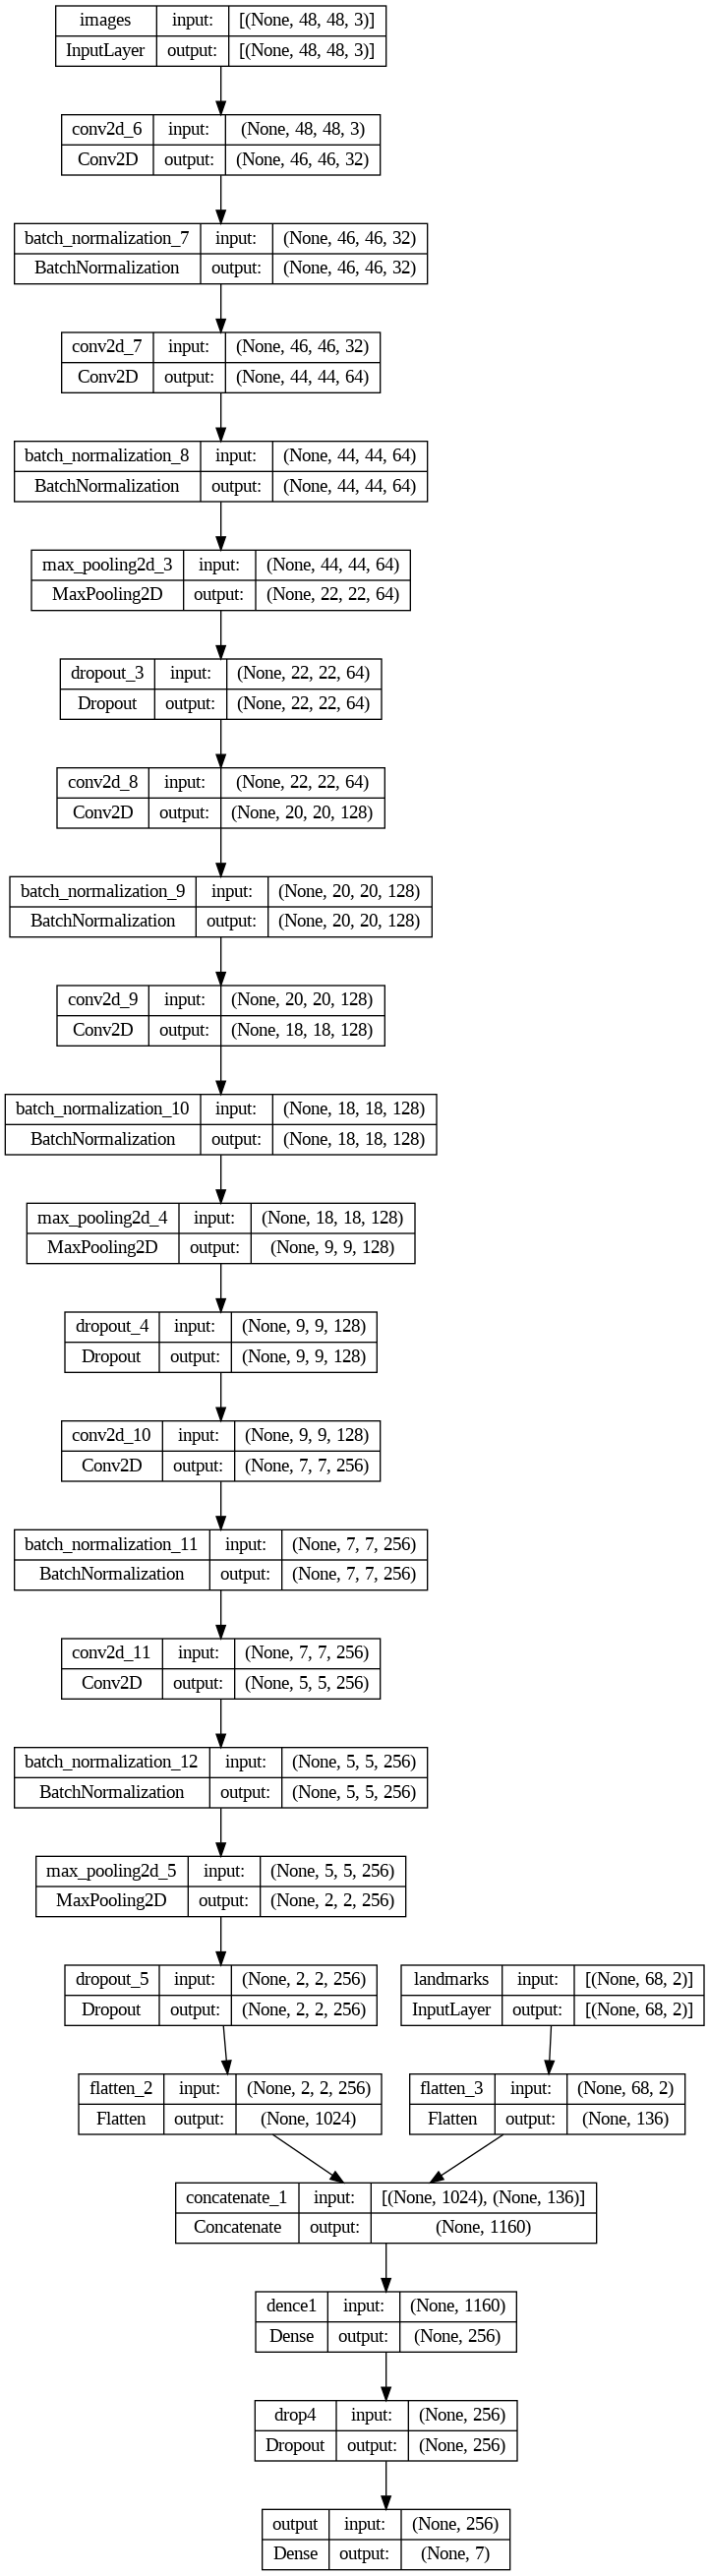

In [ ]:
utils.plot_model(nn, show_shapes=True, show_layer_names=True)

In [ ]:
history = nn.fit(x_train, train_y,
                    batch_size = 128, epochs=50, validation_split = 0.2)

Epoch 1/50
180/180 [==============================] - 20s 68ms/step - loss: 4.1511 - accuracy: 0.3180 - val_loss: 2.8656 - val_accuracy: 0.2588
Epoch 2/50
180/180 [==============================] - 11s 59ms/step - loss: 2.0117 - accuracy: 0.4434 - val_loss: 2.0882 - val_accuracy: 0.3070
Epoch 3/50
180/180 [==============================] - 11s 59ms/step - loss: 1.5144 - accuracy: 0.5009 - val_loss: 1.6047 - val_accuracy: 0.4476
Epoch 4/50
180/180 [==============================] - 11s 59ms/step - loss: 1.3478 - accuracy: 0.5372 - val_loss: 1.4663 - val_accuracy: 0.4850
Epoch 5/50
180/180 [==============================] - 11s 60ms/step - loss: 1.2739 - accuracy: 0.5549 - val_loss: 1.3992 - val_accuracy: 0.4990
Epoch 6/50
180/180 [==============================] - 11s 60ms/step - loss: 1.2136 - accuracy: 0.5807 - val_loss: 1.2881 - val_accuracy: 0.5427
Epoch 7/50
180/180 [==============================] - 11s 60ms/step - loss: 1.1684 - accuracy: 0.5991 - val_loss: 1.2703 - val_accuracy:

History data: loss, accuracy, val_loss, val_accuracy


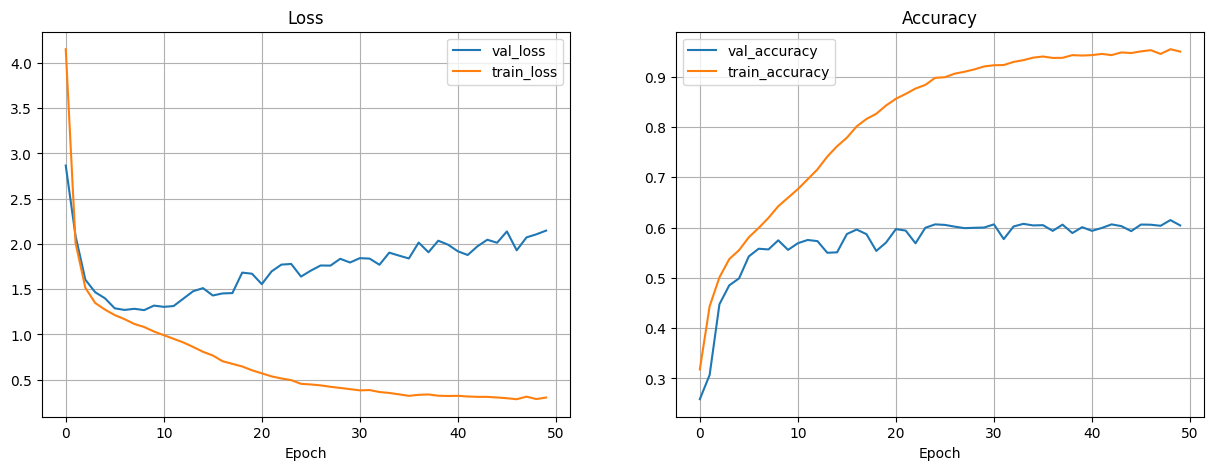

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))


print('History data: '+', '.join(history.history.keys()))
key_list = list(history.history.keys())

axes[0].plot(history.history[key_list[2]], label=key_list[2])
axes[0].plot(history.history[key_list[0]], label='train_' + key_list[0])
axes[0].grid('on')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend()

axes[1].plot(history.history[key_list[3]], label=key_list[3])
axes[1].plot(history.history[key_list[1]], label='train_' + key_list[1])
axes[1].grid('on')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].legend()

plt.show()

In [ ]:
test_loss, test_acc = nn.evaluate(x_test, test_y)
print('Test accuracy:', test_acc)

225/225 [==============================] - 2s 6ms/step - loss: 2.1801 - accuracy: 0.6002
Test accuracy: 0.6001671552658081


In [ ]:
def plot_example_errors(model, x, y):
    # Get the predicted classifications for the test-set.
    predictions = model.predict(x)

    predictions_in = np.argmax(predictions, axis=1)
    correct = (predictions_in == y)
    incorrect = (correct == False)
    images = x[0][incorrect]
    cls_pred = predictions_in[incorrect]
    cls_true = y[incorrect]
    plot_images(images=images[0:9],
    labels=cls_true[0:9],
    predictions=cls_pred[0:9])

225/225 [==============================] - 1s 4ms/step


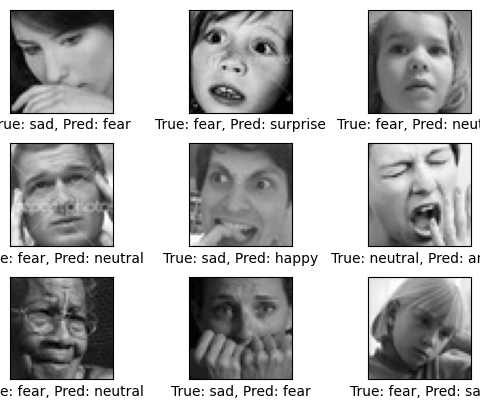

In [ ]:
plot_example_errors(nn, x_test, test_y)

In [ ]:
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(model, x, y):
    num_classes = 7
    # Get the predicted classifications for the test-set.
    predictions = model.predict(x)
    cm = confusion_matrix(y_true=y, y_pred = np.argmax(predictions,axis=1))
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names, rotation=0)
    plt.ylim(num_classes-0.5,-0.5)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

225/225 [==============================] - 1s 4ms/step
[[ 438    5  103  112  162  109   29]
 [  26   51   11   10    5    4    4]
 [  93    2  386  102  166  148  127]
 [  41    1   38 1505  113   34   42]
 [  64    1   64  173  783  122   26]
 [ 113    2  135  165  303  489   40]
 [  20    1   53   51   42    8  656]]


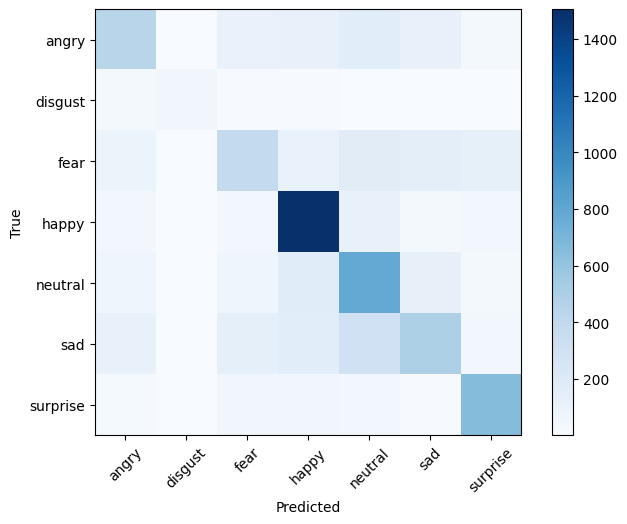

In [ ]:
print_confusion_matrix(nn, x_test, test_y)

In [ ]:
nn.save("/content/drive/MyDrive/Colab Notebooks/nn_emotion_rec.h5")